In [4]:
from __future__ import absolute_import, division, print_function

import torch
import torchvision.models as models

vgg19 = models.vgg19(pretrained=True)
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

from glob import glob
import os

import numpy as np
import pandas as pd
import json
import re

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

from PIL import Image
import base64

from embeddings import *

import warnings
warnings.simplefilter("ignore")

!pip install argparse
import argparse

/home/megsano/.local/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


In [5]:
path_to_feats = './sketch_features/FEATURES_FC6_sketch.npy' # '/home/megsano/combined_sketch_features/FEATURES_FC6_sketch.npy'
path_to_meta = './sketch_features/METADATA_sketch.csv' # '/home/megsano/combined_sketch_features/METADATA_sketch.csv'

F = np.load(path_to_feats)
M = pd.read_csv(path_to_meta)

assert F.shape[0]==M.shape[0]

In [6]:
## clean up M
def clean_up_metadata(M):
    M = M.rename(columns={'label':'path'})    
    label = [i.split('/')[-1] for i in M.path.values]    
    M = M.assign(label=pd.Series(label))
    M = M.drop(columns=['Unnamed: 0'])
    return M
    
M = clean_up_metadata(M) 

### divergence

In [7]:
## splitting up M so metadata is more accessible 
game_id_list = []
trial_num_list = []
repetition_list = []
target_list = []

for i,d in M.iterrows():
    game_id_list.append(d['label'].split("_")[0]) # first term is gameID
    trial_num_list.append(d['label'].split("_")[1]) # second term is trial number 
    repetition_list.append(d['label'].split("_")[2]) # third term is repetition 
    target_list.append(d['label'].split("_")[3] + "_" + d['label'].split("_")[4]) # third and fourth term together is target 
M['gameID'] = game_id_list
M['trialNum'] = trial_num_list
M['repetition'] = repetition_list
M['target'] = target_list
M = M.drop(["path", "label"], axis=1)
M['feature_ind'] = pd.Series(range(len(M)))

In [8]:
# create and plot RDM 
def get_and_plot_RDM(M,F,sorted_feature_ind, axs, x_ind, y_ind, rep):
    ordered_objs = M['target'].unique()
    labels = M.target.values
    means = F
    ordered_means = means[sorted_feature_ind,:]
    sns.set_style('white')
    CORRMAT = np.corrcoef(ordered_means)
    sns.set_context('paper')
    ax = axs[y_ind, x_ind]
    ax.set_title("rep {}".format(rep), fontsize=30)
    sns.heatmap(1-CORRMAT, vmin=0, vmax=2, cmap="plasma", ax=ax, cbar=False, xticklabels=False, yticklabels=False)
    RDM = CORRMAT
    plt.tight_layout()    
    return RDM

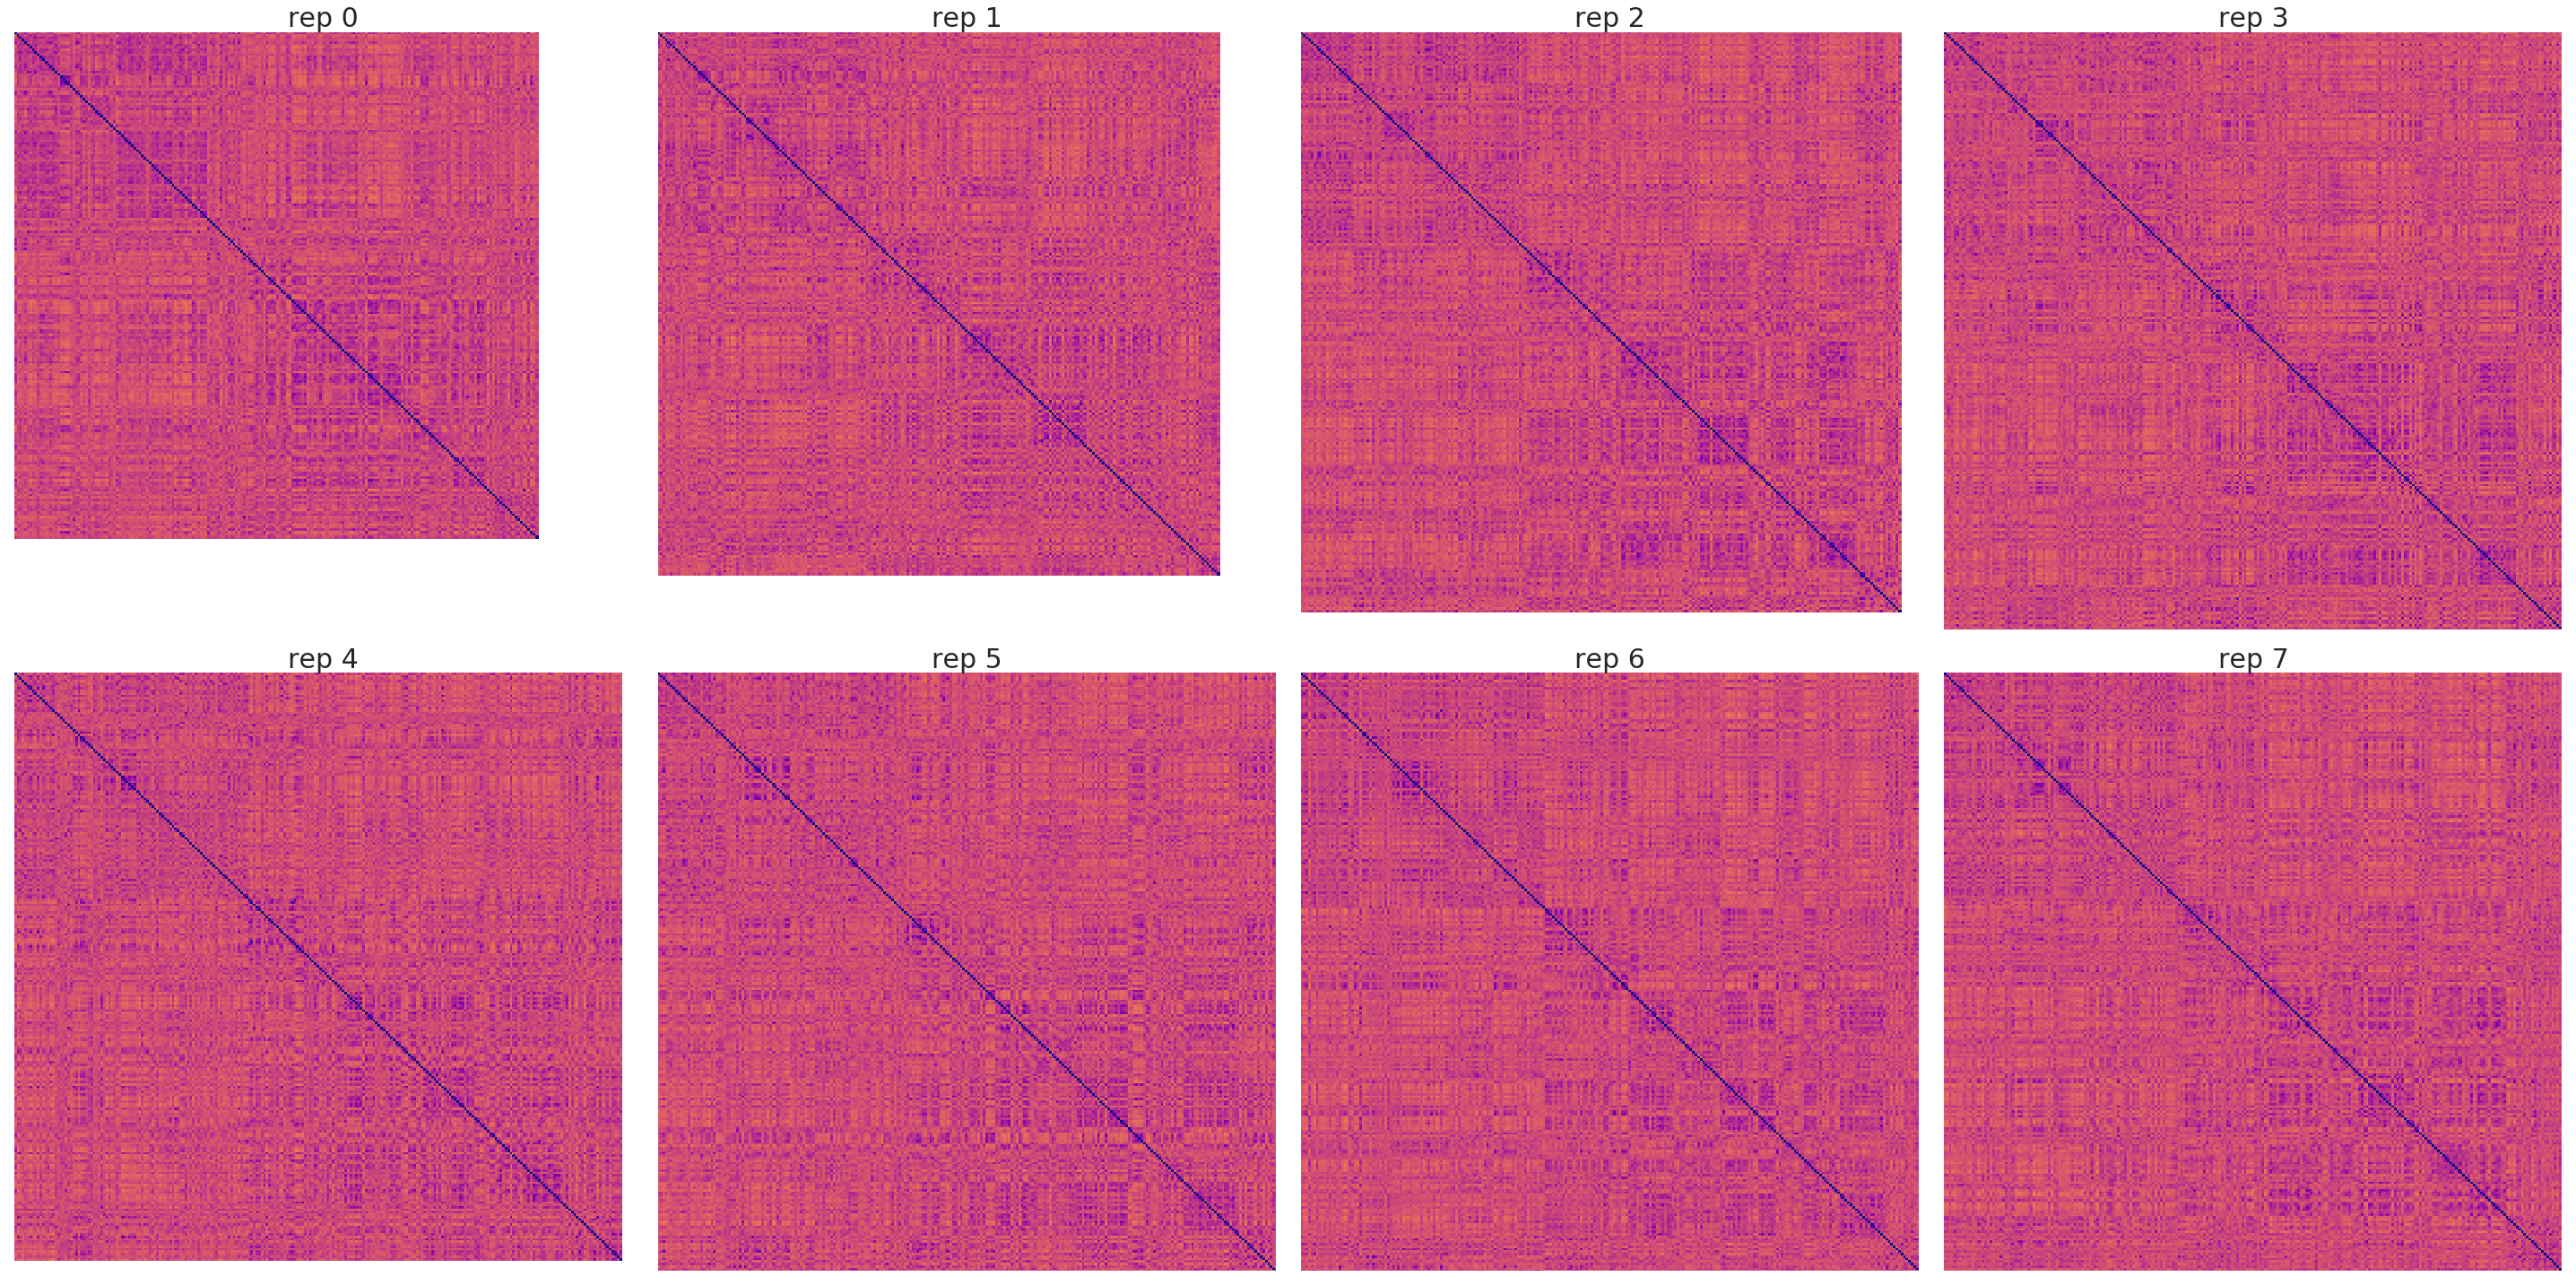

In [9]:
# plotting 8 RDMs, one for each repetition 
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(40,20))
for rep in range(8): 
    x_ind = rep % 4
    y_ind = 0 if rep < 4 else 1 
    M_rep = M[M['repetition'] == str(int(rep))]
    M_rep_sorted = M_rep.sort_values(by=['target'])
    sorted_feature_ind = list(M_rep_sorted['feature_ind'])
    get_and_plot_RDM(M_rep, F, sorted_feature_ind, axs, x_ind, y_ind, rep)

In [10]:
### computing average of upper triangle of RDM and plotting across repetitions 
new_df = pd.DataFrame()
for targ in M['target'].unique():
    M_targ = M[M['target'] == targ]
    M_targ.sort_values(by=['repetition'])
    for rep in range(8):
        M_targ_rep = M_targ[M_targ['repetition'] == str(int(rep))]
        inds_to_compare = M_targ_rep['feature_ind']
        features_to_compare = F[inds_to_compare, :]
        CORRMAT = np.corrcoef(features_to_compare)
        avr = np.mean(np.tril(CORRMAT)) # only upper triangle 
        df_to_add = pd.DataFrame([[rep, targ, avr]], columns=['repetition', 'target', 'average_similarity'])
        new_df = new_df.append(df_to_add)

(-0.5, 7.5)

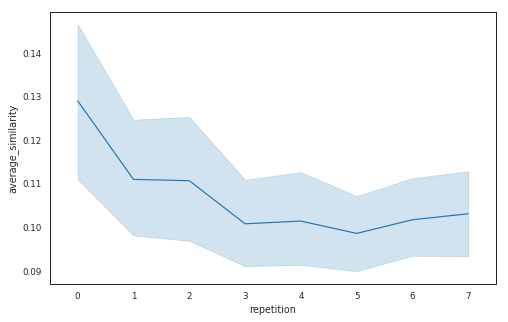

In [11]:
sns.set_context('paper')
plt.figure(figsize=(8,5))
sns.lineplot(data=new_df, x='repetition', y='average_similarity', estimator = np.mean)
plt.xlim(-0.5, 7.5)

### stability within game

In [12]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

In [13]:
# just getting the last four repetitions 
M = convert_numeric(M, 'repetition')
M_later = M[M['repetition'] > 3]

In [14]:
def compute_average_within_games(M_later_targ, order, df, gameID_str):
    total_avr = []
    for game in M_later_targ[gameID_str].unique():
        M_later_targ_game = M_later_targ[M_later_targ[gameID_str] == game]
        inds_to_compare = M_later_targ_game['feature_ind']
        features_to_compare = F[inds_to_compare, :]
        CORRMAT = np.corrcoef(features_to_compare)
        avr = np.mean(CORRMAT)
        total_avr.append(avr)
        df_to_add = pd.DataFrame([[game, targ, avr, order]], columns=['gameID', 'target', 'average_similarity', 'order'])
        df = df.append(df_to_add)
    return total_avr, df

In [15]:
# making a dataframe with both ordered and scrambled gameIDs with average similarity 
df = pd.DataFrame()
total_avr_ordered = []
total_avr_scrambled = []

# make dataframe for each target 
for targ in M_later['target'].unique():
    M_later_targ = M_later[M_later['target'] == targ]
    
    # compute average similarity within games for ordered game IDs and add to df 
    total_avr_ordered, df = compute_average_within_games(M_later_targ, 'ordered', df, 'gameID')
    
    # create pseudogameID for each of these groups by shuffling already existing gameIDs 
    gameIDs = np.array(M_later_targ['gameID'])
    np.random.shuffle(gameIDs)
    M_later_targ['pseudo_gameID'] = list(gameIDs)
    
    # compute average similarity within games for scrambled gameIDs and add to df 
    total_avr_scrambled, df = compute_average_within_games(M_later_targ, 'scrambled', df, 'pseudo_gameID')
    
mean_avr_ordered = sum(total_avr_ordered) / float(len(total_avr_ordered))
mean_avr_scrambled = sum(total_avr_scrambled) / float(len(total_avr_scrambled))

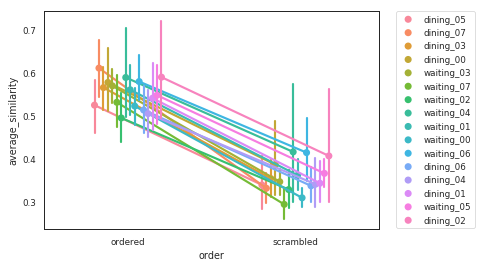

In [16]:
sns.pointplot(x='order', y='average_similarity', hue='target', data=df, dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

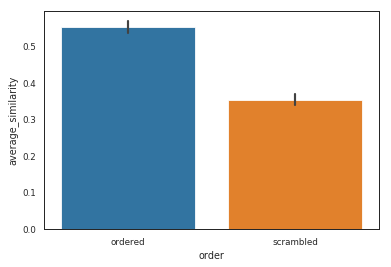

In [17]:
sns.barplot(x='order', y='average_similarity', data=df)

In [18]:
mean_avr_ordered

0.5887425043500516

In [19]:
mean_avr_scrambled

0.4060093255450793

### within-game convergence

In [20]:
# make correlation coeffiient matrix within target and within game, average them 
# M[(M['gameID'] == '3480-03933bf3-5e7e-4ecd-b151-7ae57e6ae826') & (M['target'] == 'dining_04')]
result = np.zeros((8, 8))
count = 0
F_ = np.vstack((F, [float('NaN')] * 4096))
arr_of_corrmats = []
for game in M['gameID'].unique(): #['3480-03933bf3-5e7e-4ecd-b151-7ae57e6ae826']:
    for target in (M[M['gameID'] == game])['target'].unique():  #['dining_04']:
        count = count + 1
        M_isolated = M[(M['gameID'] == game) & (M['target'] == target)]
        for rep in range(8):
            if rep not in list(M_isolated['repetition']):
                df_to_add = pd.DataFrame([[game, float('NaN'), rep, target, len(F)]], columns=['gameID', 'trialNum', 'repetition', 'target', 'feature_ind'])
                M_isolated = M_isolated.append(df_to_add)
        M_isolated_sorted = M_isolated.sort_values(by=['repetition'])
        inds_to_compare = M_isolated_sorted['feature_ind']
        features_to_compare = F_[inds_to_compare, :]
        
        # add features to a new dataframe 
        # and compute corr with pandas to handle NaN well  
        features_df = pd.DataFrame()
        column_index = 0
        for row in features_to_compare:
            features_df[str(column_index)] = pd.Series(list(row))
            column_index = column_index + 1
            
        pd_CORRMAT = features_df.corr()
        np_CORRMAT = pd_CORRMAT.values
        arr_of_corrmats.append(np_CORRMAT)
        
for i in range(8):
    for j in range(8):
        to_add = [mat[i][j] for mat in arr_of_corrmats]
        result[i][j] = np.nanmean(np.array(to_add))
     
average_corr_mat = np.array(result)

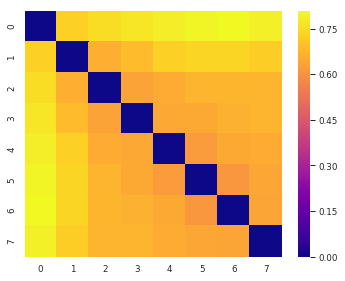

In [21]:
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(1-average_corr_mat, cmap="plasma", cbar=True, xticklabels=True, yticklabels=True, ax=ax)
plt.tight_layout()    

In [22]:
# within target 
# within repetition 
def scramble_df_within_target_rep(M):
    M_pseudo = pd.DataFrame()
    for target in M['target'].unique():
        M_targ = M[M['target'] == target]
        for rep in M_targ['repetition'].unique():
            M_targ_rep = M_targ[M_targ['repetition'] == rep]
            gameIDs = np.array(M_targ_rep['gameID'])
            np.random.shuffle(gameIDs)
            M_targ_rep['pseudo_gameID'] = list(gameIDs)
            M_pseudo = M_pseudo.append(M_targ_rep)
    return M_pseudo

In [23]:
# make correlation coeffiient matrix within target and within game, average them 
result = np.zeros((8, 8))
count = 0
F_ = np.vstack((F, [float('NaN')] * 4096))
M_pseudo = scramble_df_within_target_rep(M)
for game in M_pseudo['pseudo_gameID'].unique():
    for target in (M_pseudo[M_pseudo['gameID'] == game])['target'].unique():
        count = count + 1
        M_isolated = M_pseudo[(M_pseudo['pseudo_gameID'] == game) & (M_pseudo['target'] == target)]
        for rep in range(8):
            if rep not in list(M_isolated['repetition']):
                df_to_add = pd.DataFrame([[game, float('NaN'), rep, target, len(F)]], columns=['gameID', 'trialNum', 'repetition', 'target', 'feature_ind'])
                M_isolated = M_isolated.append(df_to_add)
        M_isolated_sorted = M_isolated.sort_values(by=['repetition'])
        inds_to_compare = M_isolated_sorted['feature_ind']
        features_to_compare = F_[inds_to_compare, :]
        
        # add features to a new dataframe 
        # and compute corr with pandas to handle NaN well  
        features_df = pd.DataFrame()
        column_index = 0
        for row in features_to_compare:
            features_df[str(column_index)] = pd.Series(list(row))
            column_index = column_index + 1
            
        pd_CORRMAT = features_df.corr()
        np_CORRMAT = pd_CORRMAT.values
        arr_of_corrmats.append(np_CORRMAT)
        
for i in range(8):
    for j in range(8):
        to_add = [mat[i][j] for mat in arr_of_corrmats]
        result[i][j] = np.nanmean(np.array(to_add))
     
average_corr_mat = np.array(result)

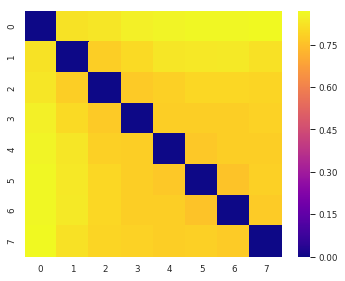

In [24]:
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(1-average_corr_mat, cmap="plasma", cbar=True, xticklabels=True, yticklabels=True, ax=ax)
plt.tight_layout()    

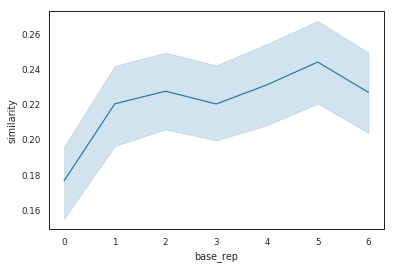

In [25]:
### just plotting one back similarities 
one_back_df = pd.DataFrame()
for base_rep in range(7):
    for i, corrmat in enumerate(arr_of_corrmats):
        corrcoef = corrmat[base_rep][base_rep+1]
        df_to_add = pd.DataFrame([[i, base_rep, corrcoef]], columns=['corrmat_num','base_rep', 'similarity']) 
        one_back_df = one_back_df.append(df_to_add)
sns.lineplot(
    data=one_back_df, 
    estimator=np.mean,
    x='base_rep',
    y='similarity')

### some more analysis on path-dependence
- negative main effect of 'round_distance' on similarity (i.e. similarity drops with more intervening rounds)
- positive main effect of 'base_round' (i.e. as the game goes on the similarity of progressive sketches gets higher)

In [23]:
auto_corr_df = pd.DataFrame()
for g in list(M['gameID'].unique()):
    for t in list(M[M['gameID'] == g]['target'].unique()):
        mini_df = M[(M['gameID'] == g) & (M['target'] == t)] 
        #mini_df = M[(M['gameID'] == '0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82') & (M['target'] == 'dining_05')] 
        for base_rep in mini_df['repetition'].unique():
            base_ind = list(mini_df[mini_df['repetition'] == base_rep]['feature_ind'])[0]
            for other_rep in mini_df['repetition'].unique():
                if base_rep < other_rep:# check if other_rep is bigger - only compare forward 
                    rep_dist = other_rep - base_rep
                    other_ind = list(mini_df[mini_df['repetition'] == other_rep]['feature_ind'])[0]
                    features_to_compare = F[[base_ind, other_ind], :]
                    corr_coef = np.corrcoef(features_to_compare)[1][0]
                    df_to_add = pd.DataFrame([[g, t, base_rep,  rep_dist, corr_coef]], columns=['gameID', 'target', 'base_rep', 'rep_dist', 'corr_coef'])
                    auto_corr_df = auto_corr_df.append(df_to_add)

In [ ]:
sns.regplot(
    data=auto_corr_df,
    x_estimator=np.mean,
    x='base_rep',
    y='corr_coef',
    logx=True)

In [ ]:
sns.regplot(
    data=auto_corr_df,
    x_estimator=np.mean,
    x='rep_dist',
    y='corr_coef')

In [ ]:
new_df_ = pd.DataFrame()
for rep in auto_corr_df['base_rep'].unique():
    df_ = auto_corr_df[auto_corr_df['base_rep'] == rep]
    for dist in df_['rep_dist'].unique():
        _df = df_[df_['rep_dist'] == dist]
        mean = np.mean(np.array(_df['corr_coef']))
        df_to_add = pd.DataFrame([[rep, dist, mean]], columns=['base_rep', 'rep_dist', 'mean_corr_coef'])
        new_df_ = new_df_.append(df_to_add)

In [ ]:
g = sns.FacetGrid(data=new_df_, col="rep_dist", height=3, aspect=1, col_wrap=4, margin_titles=True)
g = g.map(plt.scatter, "base_rep", "mean_corr_coef")
# g = sns.catplot(x="base_rep", y="mean_corr_coef",
#                 col="rep_dist", data=new_df_,col_wrap=2)

### training a classifier on each repetition and predicting other repetitions to measure "transfer" between repetitions

In [26]:
#sklearn
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics  import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

In [24]:
# make dataframe with just the first repetition 
M_0 = M[M['repetition'] == 0]
y = list(M_0['target'])
feature_inds = list(M_0['feature_ind'])
features = F[feature_inds, :]
x = pd.DataFrame(features)

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(x, y, test_size = 0.2)

# make dataframe with just the last repetition 
M_7 = M[M['repetition'] == 7]
y = list(M_7['target'])
feature_inds = list(M_7['feature_ind'])
features = F[feature_inds, :]
x = pd.DataFrame(features)

X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(x, y, test_size = 0.2)

##### checking performance of linear SVC

In [25]:
svc = LinearSVC(random_state=0)
clf = CalibratedClassifierCV(svc) 
clf.fit(X_train_0, y_train_0)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

In [26]:
y_pred = clf.predict(X_test_0)
acc = accuracy_score(y_test_0, y_pred)
print("Accuracy: {}".format(acc*100))

Accuracy: 26.1904761905


In [27]:
y_pred =clf.predict(X_test_7)
acc = accuracy_score(y_test_7, y_pred)
print("Accuracy: {}".format(acc*100))

Accuracy: 32.6530612245


##### multinomial logistic regression

In [28]:
log = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf = CalibratedClassifierCV(log) 
clf.fit(X_train_0, y_train_0)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

In [29]:
y_pred = clf.predict(X_test_0)
acc = accuracy_score(y_test_0, y_pred)
print("Accuracy: {}".format(acc*100))

Accuracy: 50.0


In [30]:
y_pred =clf.predict(X_test_7)
acc = accuracy_score(y_test_7, y_pred)
print("Accuracy: {}".format(acc*100))

Accuracy: 36.7346938776


### accuracy and class probability depending on test repetition 

In [27]:
# makes training and testing sets for sketches from specific repetition 
def make_sets(M, rep):
    # make dataframe with just the last repetition 
    M_= M[M['repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return train_test_split(x, y, test_size = 0.2)

In [28]:
# make either training set or testing set (all sketches used for either one of them)
def get_x_and_y(M, rep):
    M_= M[M['repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return x, y

In [29]:
def classify_sketches(train_rep, test_rep):
    summary_df = pd.DataFrame()
    for i in range(1):
    
        # first train on the train_rep sketches
        X_train_, y_train_= get_x_and_y(M, train_rep)
        logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
        #clf = CalibratedClassifierCV(log) 
        logreg.fit(X_train_, y_train_)
#         svc = LinearSVC(random_state=0)
#         clf = CalibratedClassifierCV(svc) 
#         clf.fit(X_train_, y_train_)

        # for each repetition, predict from features, record accuracy and class probability    
        for rep in test_rep:
            X_test, y_test = get_x_and_y(M, rep)
            y_pred = logreg.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            prob = logreg.predict_proba(X_test)
            prob_df_svc = pd.DataFrame(prob)
            prob_df_svc.columns=list(logreg.classes_)
            prob_df_svc['target'] = y_test
            prob_list = []
            prob_df_svc = prob_df_svc.reset_index(drop=True)
            for j, d in prob_df_svc.iterrows():
                target = d['target']
                class_prob = d[target]
                prob_list.append(class_prob)
            mean_prob = np.mean(prob_list)

            df_to_add = pd.DataFrame([[i, rep, acc, mean_prob]], columns=['iteration','test_rep', 'accuracy', 'class_prob'])
            summary_df = summary_df.append(df_to_add)

    return summary_df

In [30]:
summary_df0 = classify_sketches(0, [1,7])
summary_df7 = classify_sketches(7, [6,0])
summary_df0['train_rep'] = [0] * summary_df0.shape[0]
summary_df7['train_rep'] = [7] * summary_df7.shape[0]
summary_df_list = [summary_df0, summary_df7]
combined_df = pd.concat(summary_df_list, axis=0)
combined_df = combined_df.reset_index(drop=True)
distance_list = []
for i,d in combined_df.iterrows():
    distance_list.append(abs(d['test_rep']-d['train_rep']))
combined_df['distance'] = distance_list
combined_df = combined_df.reset_index(drop=True)

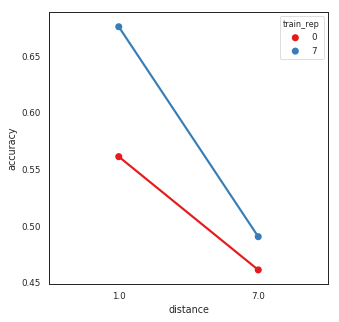

In [31]:
sns.set_context("paper")
plt.figure(figsize=(5,5))
sns.pointplot(
    data=combined_df,
    x='distance',
    y='accuracy',
    hue='train_rep',
    palette="Set1")

### permutation test 

In [30]:
def get_x_and_y_permute(M, rep):
    M_= M[M['pseudo_repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return x, y

In [31]:
def classify_sketches_permute(train_rep, test_rep):
    summary_df = pd.DataFrame()
    
    # first train on the train_rep sketches
    X_train_, y_train_= get_x_and_y_permute(M, train_rep)
    logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    #clf = CalibratedClassifierCV(log) 
    logreg.fit(X_train_, y_train_)
#         svc = LinearSVC(random_state=0)
#         clf = CalibratedClassifierCV(svc) 
#         clf.fit(X_train_, y_train_)

    # for each repetition, predict from features, record accuracy and class probability    
    for rep in test_rep:
        X_test, y_test = get_x_and_y_permute(M, rep)
        y_pred = logreg.predict(X_test)
        acc = accuracy_score(y_test, y_pred) # temporarily just do accuracy 
#         prob = logreg.predict_proba(X_test)
#         prob_df_svc = pd.DataFrame(prob)
#         prob_df_svc.columns=list(logreg.classes_)
#         prob_df_svc['target'] = y_test
#         prob_list = []
#         prob_df_svc = prob_df_svc.reset_index(drop=True)
#         for j, d in prob_df_svc.iterrows():
#             target = d['target']
#             class_prob = d[target]
#             prob_list.append(class_prob)
        mean_prob = 1#np.mean(prob_list)

        df_to_add = pd.DataFrame([[i, rep, acc, mean_prob]], columns=['iteration','test_rep', 'accuracy', 'class_prob'])
        summary_df = summary_df.append(df_to_add)

    return summary_df

In [41]:
final_combined_df_permute = pd.DataFrame()
random_seed = 4000000000
for i in range(1000):
    if i % 100 == 0:
        print (str(i) + "th iteration")
    pseudo_rep_list = []
    for g in list(M['gameID'].unique()):
        for t in list(M[M['gameID'] == g]['target'].unique()):
            mini_df = M[(M['gameID'] == g) & (M['target'] == t)] 
            rep_list = np.array(mini_df['repetition'])
            # pass in different random seed for each one 
            np.random.seed(random_seed)
            shuffled_rep_list = np.random.permutation(rep_list)
            pseudo_rep_list = pseudo_rep_list + list(shuffled_rep_list)
            random_seed = random_seed - 1
    M['pseudo_repetition'] = pseudo_rep_list
    summary_df0 = classify_sketches_permute(0, [1,7])
    summary_df7 = classify_sketches_permute(7, [6,0])
    summary_df0['train_rep'] = [0] * summary_df0.shape[0]
    summary_df7['train_rep'] = [7] * summary_df7.shape[0]
    summary_df_list = [summary_df0, summary_df7]
    combined_df_permute = pd.concat(summary_df_list, axis=0)
    combined_df_permute = combined_df_permute.reset_index(drop=True)
    distance_list = []
    for j,d in combined_df_permute.iterrows():
        distance_list.append(abs(d['test_rep']-d['train_rep']))
    combined_df_permute['distance'] = distance_list
    combined_df_permute = combined_df_permute.reset_index(drop=True)
    final_combined_df_permute = final_combined_df_permute.append(combined_df_permute)#add(combined_df_permute, fill_value=0)
result = final_combined_df_permute / 1000

0th iteration
100th iteration
200th iteration
300th iteration
400th iteration
500th iteration
600th iteration
700th iteration
800th iteration
900th iteration


[(0.5, 0.6)]

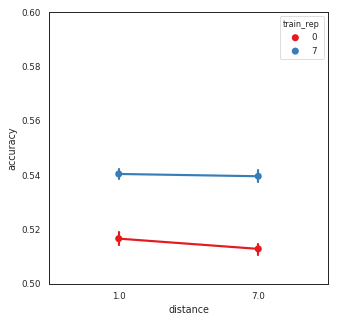

In [42]:
sns.set_context("paper")
plt.figure(figsize=(5,5))
g = sns.pointplot(
    data=final_combined_df_permute,
    x='distance',
    y='accuracy',
    hue='train_rep',
    palette="Set1")
g.set(ylim=(0.5, 0.6))

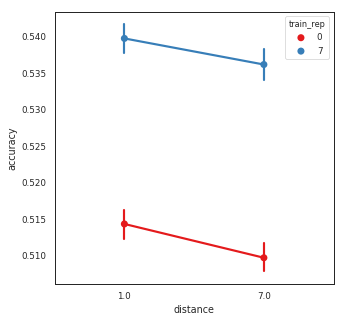

In [67]:
sns.set_context("paper")
plt.figure(figsize=(5,5))
sns.pointplot(
    data=final_combined_df_permute,
    x='distance',
    y='accuracy',
    hue='train_rep',
    palette="Set1")

### bootstrap

In [32]:
# make either training set or testing set (all sketches used for either one of them)
from sklearn.metrics import log_loss
def get_x_and_y(M, rep):
    M_= M[M['repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return x, y

def get_training_set_error(train_rep):
    X_train, y_train = get_x_and_y(M, train_rep)
    targets = pd.Series(y_train).unique()
    logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    logreg.fit(X_train, y_train)
    #y_pred = logreg.predict(X_test)
    y_pred = logreg.predict_proba(X_train)
    # train classifier on these sample sketches from repetition (train) and test on sketches from game g repetition (test)
    classification_loss = log_loss(y_train, y_pred, labels=targets)
    return classification_loss

In [31]:
games = list(M['gameID'].unique())
#targets = list(M['target'].unique())
number_of_games = len(games)

bootstrap_samples = []
for i in range(1000):
    sample = np.random.choice(number_of_games, number_of_games)
    bootstrap_samples.append(sample)
    
def get_error(train_rep, test_rep):
    
    #grand_total_classification_loss = 0
    err_df = pd.DataFrame()
    for g in games:
        print("computing average classification loss for game " + g + " with train rep: " + str(train_rep) + " and test rep: " + str(test_rep))

        samples_without_g = [sample for sample in bootstrap_samples if games.index(g) not in sample] 
        total_classification_loss = 0
        training_set_error = get_training_set_error(train_rep)
        sample_index=0
        for sample in samples_without_g:
            games_ = pd.Series(games)
            sample_games = games_[sample] # sample is just a list of indices, so get actual games 
            sample_games = list(sample_games)
            M_train = M[M['gameID'].isin(sample_games)]
            X_train, y_train = get_x_and_y(M_train, train_rep)
            targets = pd.Series(y_train).unique()
            M_test = M[M['gameID'] == g]
            X_test, y_test = get_x_and_y(M_test, test_rep)
            logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
            logreg.fit(X_train, y_train)
            #y_pred = logreg.predict(X_test)
            y_pred = logreg.predict_proba(X_test)
            # train classifier on these sample sketches from repetition (train) and test on sketches from game g repetition (test)
            classification_loss = log_loss(y_test, y_pred, labels=targets)
            total_classification_loss = total_classification_loss + classification_loss
            sample_index=sample_index+1
        average_classification_loss = total_classification_loss / len(samples_without_g)
        error = 0.632 * average_classification_loss + 0.368 * training_set_error
        df_to_add = pd.DataFrame([[error, g, sample_index, train_rep, test_rep]], columns=['error', 'gameID', 'sample_index', 'train_rep', 'test_rep'])
        err_df = err_df.append(df_to_add)
        #grand_total_classification_loss = grand_total_classification_loss + average_classification_loss
    #grand_average_classification_loss = grand_total_classification_loss / len(games)

    #error_632 = 0.632 * grand_average_classification_loss + 0.368 * training_set_error 
    return err_df

# df_0_1 = get_error(0,1)
# df_0_1.to_csv("df_0_1.csv")
df_0_7 = get_error(0,7)
df_0_7.to_csv("df_0_7.csv")
df_7_6 = get_error(7,6)
df_7_6.to_csv("df_7_6.csv")
df_7_0 = get_error(7,0)
df_7_0.to_csv("df_7_0.csv")

computing average classification loss for game 0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82 with train rep: 0 and test rep: 7
computing average classification loss for game 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f with train rep: 0 and test rep: 7
computing average classification loss for game 0232-52e2508f-1993-48fa-8bb3-3d1bb74dfc40 with train rep: 0 and test rep: 7
computing average classification loss for game 0286-a442ec93-ad78-42fa-b3e9-083da9a64c4d with train rep: 0 and test rep: 7
computing average classification loss for game 0647-0ece0513-aa05-4676-bb63-3845126ce2c1 with train rep: 0 and test rep: 7
computing average classification loss for game 0724-1a59371c-6fe6-4d6d-a987-db533e75a5e5 with train rep: 0 and test rep: 7
computing average classification loss for game 0786-9d8492b6-e57d-4cb6-a44e-a79bccb681f4 with train rep: 0 and test rep: 7
computing average classification loss for game 0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b with train rep: 0 and test rep: 7
computing averag

computing average classification loss for game 9817-6f2a66db-fc24-482d-aa20-1980ad6f524e with train rep: 0 and test rep: 7
computing average classification loss for game 0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82 with train rep: 7 and test rep: 6
computing average classification loss for game 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f with train rep: 7 and test rep: 6
computing average classification loss for game 0232-52e2508f-1993-48fa-8bb3-3d1bb74dfc40 with train rep: 7 and test rep: 6
computing average classification loss for game 0286-a442ec93-ad78-42fa-b3e9-083da9a64c4d with train rep: 7 and test rep: 6
computing average classification loss for game 0647-0ece0513-aa05-4676-bb63-3845126ce2c1 with train rep: 7 and test rep: 6
computing average classification loss for game 0724-1a59371c-6fe6-4d6d-a987-db533e75a5e5 with train rep: 7 and test rep: 6
computing average classification loss for game 0786-9d8492b6-e57d-4cb6-a44e-a79bccb681f4 with train rep: 7 and test rep: 6
computing averag

computing average classification loss for game 9790-3a0dd9df-cae0-4f97-95b4-93bf1d0bfd09 with train rep: 7 and test rep: 6
computing average classification loss for game 9817-6f2a66db-fc24-482d-aa20-1980ad6f524e with train rep: 7 and test rep: 6
computing average classification loss for game 0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82 with train rep: 7 and test rep: 0
computing average classification loss for game 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f with train rep: 7 and test rep: 0
computing average classification loss for game 0232-52e2508f-1993-48fa-8bb3-3d1bb74dfc40 with train rep: 7 and test rep: 0
computing average classification loss for game 0286-a442ec93-ad78-42fa-b3e9-083da9a64c4d with train rep: 7 and test rep: 0
computing average classification loss for game 0647-0ece0513-aa05-4676-bb63-3845126ce2c1 with train rep: 7 and test rep: 0
computing average classification loss for game 0724-1a59371c-6fe6-4d6d-a987-db533e75a5e5 with train rep: 7 and test rep: 0
computing averag

computing average classification loss for game 9769-9f38f477-8dbd-4976-96fa-d359b0d05222 with train rep: 7 and test rep: 0
computing average classification loss for game 9790-3a0dd9df-cae0-4f97-95b4-93bf1d0bfd09 with train rep: 7 and test rep: 0
computing average classification loss for game 9817-6f2a66db-fc24-482d-aa20-1980ad6f524e with train rep: 7 and test rep: 0


NameError: name 'df_0_1' is not defined

In [32]:
df_0_1 = pd.read_csv("df_0_1.csv")
all_err_df = pd.concat([df_0_1, df_0_7, df_7_6, df_7_0])
all_err_df.to_csv("all_err_df.csv")

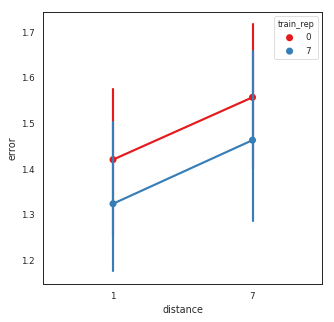

In [33]:
# convert to and add distance 
all_err_df = pd.read_csv("all_err_df.csv")
distance_list = []
for j,d in all_err_df.iterrows():
    distance_list.append(abs(d['test_rep']-d['train_rep']))
all_err_df['distance'] = distance_list

sns.set_context("paper")
plt.figure(figsize=(5,5))
sns.pointplot(
    data=all_err_df,
    x='distance',
    y='error',
    hue='train_rep',
    palette="Set1")

In [70]:
average_classification_loss
# 7438 - 68

4.575201238620788

In [58]:
y_pred[0]

array([1.02324913e-04, 9.09633290e-05, 2.04339450e-04, 4.63713396e-04,
       1.37156850e-04, 5.93329670e-05, 3.15393046e-05, 1.03033392e-03,
       2.95892496e-02, 1.96745036e-04, 4.17515203e-04, 9.62987277e-01,
       5.60619994e-04, 1.04249306e-04, 4.02463961e-03])

In [51]:
M['target'].unique()

array(['dining_05', 'dining_03', 'dining_07', 'dining_00', 'waiting_07',
       'waiting_03', 'waiting_02', 'waiting_04', 'waiting_01',
       'waiting_00', 'waiting_06', 'dining_04', 'dining_06', 'dining_01',
       'waiting_05', 'dining_02'], dtype=object)

In [50]:
combined_df_ = combined_df.copy(deep=True)
combined_df_.reset_index()
new_repetition = []
for i,d in combined_df_.iterrows():
    current_rep = d['repetition']
    new_repetition.append(current_rep+1)
combined_df_['new_repetition'] = new_repetition

KeyError: 'repetition'

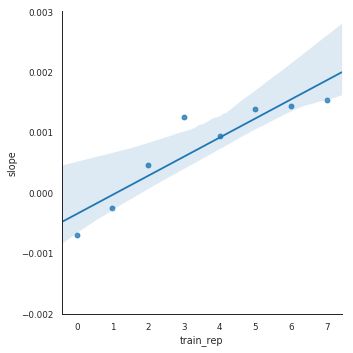

In [83]:
# looking at how slope of the transfer changes depending on train_rep 
import statsmodels
from scipy import stats

slope_df = pd.DataFrame()
slope_df['train_rep'] = range(8)
slope_list = []
for train_rep in range(8):
    df_rep = combined_df[combined_df['train_rep'] == train_rep]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_rep['test_rep'],df_rep['class_prob'])
    slope_list.append(slope)
slope_df['slope'] = slope_list

ax = sns.lmplot(
    data=slope_df,
    x='train_rep',
    y='slope')
ax.set(ylim=(-0.002, 0.003))

In [1]:
# sns.lmplot(
#     data=combined_df,
#     x='test_rep',
#     y='class_prob',
#     hue='train_rep',
#     col='train_rep',
#     col_wrap=4,
#     truncate=True,
#     palette="Set1")

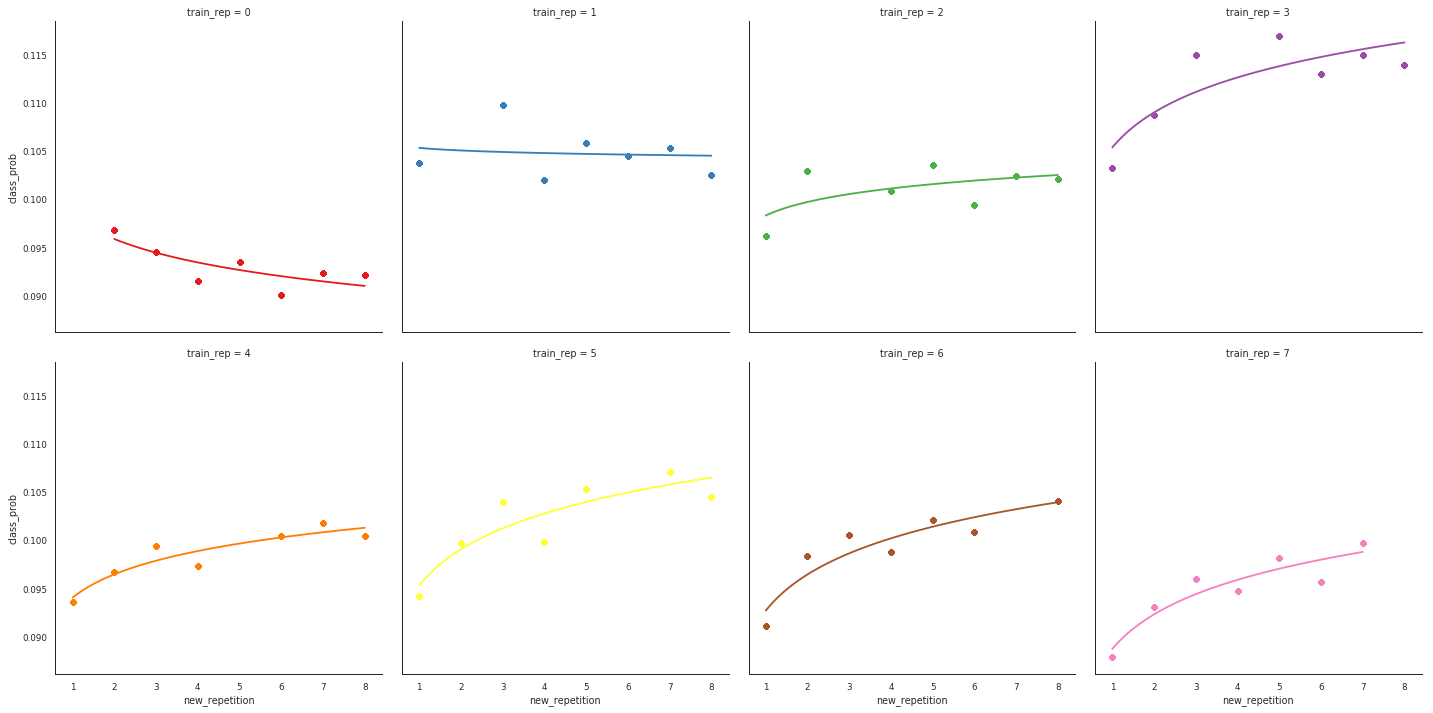

In [72]:
sns.lmplot(
    data=combined_df_,
    x='new_repetition',
    y='class_prob',
    hue='train_rep',
    col='train_rep',
    col_wrap=4,
    truncate=True,logx=True,
    palette="Set1")

In [64]:
### aggregating within rep (to see which rep has highest average accuracy)
rep_df = pd.DataFrame()
rep_class_prob_list = []
rep_accuracy_list = []
for rep in range(8):
    df_rep = combined_df[combined_df['train_rep'] == rep]
    rep_class_prob_list.append(np.mean(df_rep['class_prob']))
    rep_accuracy_list.append(np.mean(df_rep['accuracy']))
rep_df['train_rep'] = range(8)
rep_df['mean_class_prob'] = rep_class_prob_list
rep_df['mean_accuracy'] = rep_accuracy_list

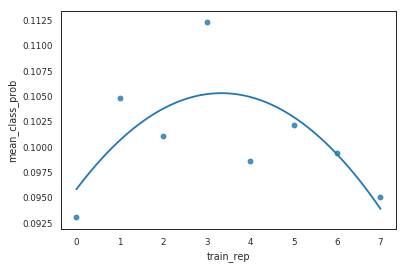

In [66]:
sns.regplot(
    data=rep_df,
    x='train_rep',
    y='mean_class_prob',
    order=2, truncate=True, ci=None)

### looking at transfer from general rep 0 games to one game's rep 0 and rep 7

In [51]:
# makes training and testing sets for sketches from specific repetition 
def make_sets(M, rep):
    # make dataframe with just the last repetition 
    M_= M[M['repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return train_test_split(x, y, test_size = 0.2)

In [54]:
transfer_df = pd.DataFrame()

# pick one game, game g
for g in M['gameID'].unique():
    
    # train on rep 0 sketches from all other games 
    M_without_g = M[M['gameID'] != g]
    X_train_else, y_train_else = get_x_and_y(M_without_g, 0)
    svc = LinearSVC(random_state=0)
    clf = CalibratedClassifierCV(svc) 
    clf.fit(X_train_else, y_train_else)
    
    # make dataframe with just game X 
    M_g = M[M['gameID'] == g]
    
    # predict (get accuracy and class prob) for rep 0 and 7 of game g
    for rep in [0, 7]:
        X_test_g, y_test_g = get_x_and_y(M_g, rep)
        y_pred = clf.predict(X_test_g)
        acc = accuracy_score(y_test_g, y_pred)
        prob = clf.predict_proba(X_test_g)
        prob_df_svc = pd.DataFrame(prob)
        prob_df_svc.columns=list(clf.classes_)
        prob_df_svc['target'] = y_test_g
        prob_list = []
        for i, d in prob_df_svc.iterrows():
            target = d['target']
            class_prob = d[target]
            prob_list.append(class_prob)
        mean_prob = np.mean(prob_list)
        df_to_add = pd.DataFrame([[g, rep, acc, mean_prob]], columns=['gameID','repetition', 'accuracy', 'class_prob'])
        transfer_df = transfer_df.append(df_to_add)

In [55]:
y_pred = clf.predict(X_test_else)
acc = accuracy_score(y_test_else, y_pred)
prob = clf.predict_proba(X_test_else)
prob_df_svc = pd.DataFrame(prob)
prob_df_svc.columns=list(clf.classes_)
prob_df_svc['target'] = y_test_else
prob_list = []
for i, d in prob_df_svc.iterrows():
    target = d['target']
    class_prob = d[target]
    prob_list.append(class_prob)
mean_prob = np.mean(prob_list)

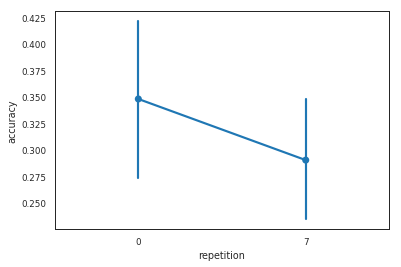

In [59]:
sns.pointplot(x='repetition', y='accuracy', data=transfer_df, dodge=False, estimator = np.mean)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

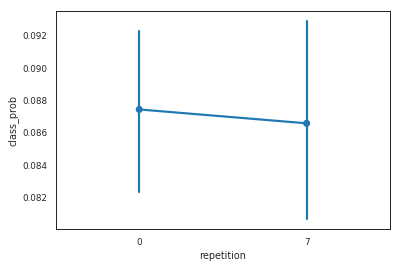

In [61]:
sns.pointplot(x='repetition', y='class_prob', data=transfer_df, dodge=False, estimator = np.mean)